In [2]:
import os
import random
import time
from pathlib import Path
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
# Checking Device/confirming it works with CUDA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

x = torch.randn(10000, 10000, device=device)
print("Computation successful on", device)

Using device: cuda
Computation successful on cuda


In [ ]:
# Helper Functions

def subset_dataset(dataset, percent, seed=6050):
    if percent >= 1.0:
        return dataset
    
    random.seed(seed)
    subset_size = int(len(dataset) * percent)
    indices = random.sample(range(len(dataset)), subset_size)
    return Subset(dataset, indices)

def plot_loss_and_acc(track_loss, track_train_acc, track_val_acc):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(track_train_acc, label="Train")
    plt.plot(track_val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(track_loss, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# CONFIGURATION

data_root = Path(r"C:/Users/Jimmy/OneDrive/Desktop/test/DS6050_Ai_Detection")  # adjust as needed
train_dir = data_root / "train"
val_dir = data_root / "validation"

batch_size = 32
num_workers = 4
num_epochs = 5
learning_rate = 1e-4
train_percent = 0.5  # train/validate on 50% of data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# DATA TRANSFORMS

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize for ResNet
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

'''
resize will resize the image to 256x256
randomcrop will random crop a 224x224 image from the 256x256 image
randomhorizontalflip will randomly flip the image horizontally

toTensor will convert the image to a tensor
normalize will normalize the image, values are picked from imagenet mean and std, which the resnet50 is pretrained on

'''

'\nresize will resize the image to 256x256\nrandomcrop will random crop a 224x224 image from the 256x256 image\nrandomhorizontalflip will randomly flip the image horizontally\n\ntoTensor will convert the image to a tensor\nnormalize will normalize the image, values are picked from imagenet mean and std, which the resnet50 is pretrained on\n\n'

In [ ]:
# dataloader loads alphabetically, so we need to swap labels
class CustomImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        # Swap label: make 'real' = 0, 'fake' = 1
        label = 1 - label
        return img, label

In [9]:
# LOAD DATASETS

train_dataset = CustomImageFolder(root=str(train_dir), transform=transform)
val_dataset = CustomImageFolder(root=str(val_dir), transform=transform)

print("Original class mapping:", train_dataset.class_to_idx)  # still 'fake':0, 'real':1

# train_dataset = subset_dataset(train_dataset, train_percent)
# val_dataset = subset_dataset(val_dataset, train_percent)

#DATALOADERS
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training on {len(train_dataset)} images, validating on {len(val_dataset)} images.")

Original class mapping: {'fake': 0, 'real': 1}
Training on 115200 images, validating on 28340 images.


In [ ]:
subset = train_dataset

for idx in range(10):
    if isinstance(subset, torch.utils.data.Subset):
        actual_idx = subset.indices[idx]
        img, label = subset[idx]
        path = subset.dataset.imgs[actual_idx][0]
    else:
        img, label = subset[idx]
        path = subset.imgs[idx][0]

    print(f"{path} --> Label: {label}")

C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000001.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000002.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000003.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000004.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000006.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000008.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000012.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000013.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000014.png --> Label: 1
C:\Users\Jimmy\OneDrive\Desktop\test\DS6050_Ai_Detection\train\fake\000017.png --> Label: 1


In [ ]:
# MODEL SETUP (ResNet50)

model = models.resnet50(weights=True)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),   # hidden layer
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)           # final output
)

model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # adding label smoothing for better generalization

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # adding L2 regularization

c:\Users\Jimmy\miniconda3\envs\id_ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


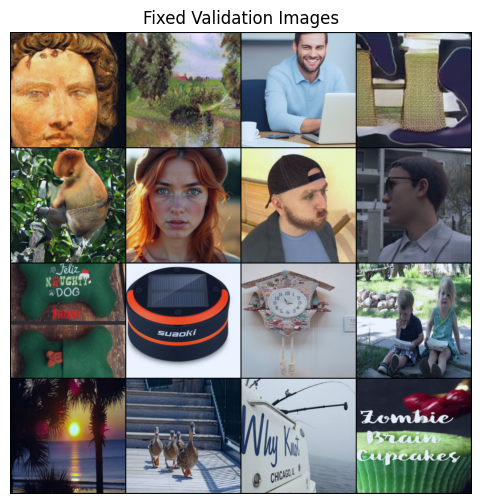

Fake: 033363.png
Fake: 017684.png
Fake: 018795.png
Fake: 020552.png
Fake: 010248.png
Fake: 015131.png
Fake: 007417.png
Fake: 027489.png
Real: 0006900.png
Real: 0002155.png
Real: 000000161642.jpg
Real: 000000303893.jpg
Real: 0011259.png
Real: 000000166259.jpg
Real: 0015257.png
Real: 0000079.png


In [25]:
# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# random.seed(SEED)

grid_size = 4
num_images = grid_size * grid_size

if isinstance(val_dataset, torch.utils.data.Subset):
    subset = val_dataset
    base = val_dataset.dataset

    all_indices = subset.indices
    all_paths  = [base.samples[i][0] for i in all_indices]
    all_labels = [base.samples[i][1] for i in all_indices]

else:
    all_paths  = [p for p, l in val_dataset.samples]
    all_labels = [l for p, l in val_dataset.samples]

labels_tensor = torch.tensor(all_labels)

real_indices = (labels_tensor == 0).nonzero(as_tuple=True)[0]
fake_indices = (labels_tensor == 1).nonzero(as_tuple=True)[0]

half_num = num_images // 2
real_sample = real_indices[torch.randperm(len(real_indices))[:half_num]]
fake_sample = fake_indices[torch.randperm(len(fake_indices))[:half_num]]

subset_indices = torch.cat([real_sample, fake_sample])

if isinstance(val_dataset, torch.utils.data.Subset):
    base = val_dataset.dataset
    original_indices = [all_indices[i.item()] for i in subset_indices]

    fixed_images = torch.stack([base[i][0] for i in original_indices]).to(device)
    fixed_labels = torch.tensor([base[i][1] for i in original_indices]).to(device)
    fixed_paths  = [all_paths[i] for i in subset_indices]

else:
    fixed_images = torch.stack([val_dataset[i][0] for i in subset_indices]).to(device)
    fixed_labels = torch.tensor([val_dataset[i][1] for i in subset_indices]).to(device)
    fixed_paths  = [all_paths[i] for i in subset_indices]

grid_img = make_grid(fixed_images.cpu(), nrow=grid_size, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(grid_img.numpy(), (1,2,0)))
plt.axis("off")
plt.title("Fixed Validation Images")
plt.show()

for path, lbl in zip(fixed_paths, fixed_labels):
    print(f"{'Real' if lbl==0 else 'Fake'}: {os.path.basename(path)}")


In [ ]:
# Training loop

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_acc = 0.0
    start_time = time.time()

    track_loss = []
    track_train_acc = []
    track_val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\n🔹 Epoch {epoch+1}/{num_epochs}")

        # Wrap train loader with tqdm
        train_pbar = tqdm(train_loader, desc="Training", unit="batch")
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_acc = 100 * correct / total
            avg_loss = running_loss / (len(train_loader) if len(train_loader) > 0 else 1)

            # Live update progress bar
            train_pbar.set_postfix({
                "Loss": f"{avg_loss:.4f}",
                "Train Acc": f"{train_acc:.2f}%"
            })

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_pbar = tqdm(val_loader, desc="Validating", unit="batch", leave=False)
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

            #-------------images
            outputs_grid = model(fixed_images)
            preds_grid = torch.argmax(outputs_grid, dim=1)

        val_acc = 100 * val_correct / val_total

        label_names = ['Real', 'Fake']
        true_names = [label_names[l.item()] for l in fixed_labels]
        pred_names = [label_names[p.item()] for p in preds_grid]

        # Create the figure
        fig, axs = plt.subplots(3, 1, figsize=(8, 8))

        # Row 1: Image grid
        grid_img = make_grid(fixed_images.cpu(), nrow=grid_size, normalize=True)
        axs[0].imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
        axs[0].set_title("Validation Samples")
        axs[0].axis("off")

        # Image dimensions for positioning labels
        img_w = grid_img.shape[2] // grid_size
        img_h = grid_img.shape[1] // grid_size

        # Row 2: True labels (white background + text)
        axs[1].imshow(np.ones((img_h * grid_size, img_w * grid_size, 3)))
        axs[1].set_title("True Labels")
        axs[1].axis("off")
        for i, lbl in enumerate(true_names):
            axs[1].text(
                (i % grid_size + 0.5) * img_w,
                (i // grid_size + 0.5) * img_h,
                lbl,
                ha='center', va='center', fontsize=14, color='black'
            )

        # Row 3: Predicted labels (green/red text for correctness)
        axs[2].imshow(np.ones((img_h * grid_size, img_w * grid_size, 3)))
        axs[2].set_title("Predicted Labels")
        axs[2].axis("off")
        for i, lbl in enumerate(pred_names):
            color = 'green' if lbl == true_names[i] else 'red'
            axs[2].text(
                (i % grid_size + 0.5) * img_w,
                (i // grid_size + 0.5) * img_h,
                lbl,
                ha='center', va='center', fontsize=14, color=color
            )

        plt.tight_layout()
        plt.show()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet50_baseline.pth")

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        
        track_loss.append(avg_loss)
        track_train_acc.append(train_acc)
        track_val_acc.append(val_acc)

    print(f"\nTraining complete in {(time.time() - start_time)/60:.2f} minutes.")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    
    plot_loss_and_acc(track_loss, track_train_acc, track_val_acc)

    return track_loss, track_train_acc, track_val_acc

## Run 11/14 0900

In [ ]:
all_metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

## Run 11/15 1230


🔹 Epoch 1/10


Training: 100%|██████████| 3600/3600 [16:56<00:00,  3.54batch/s, Loss=0.2656, Train Acc=96.14%]


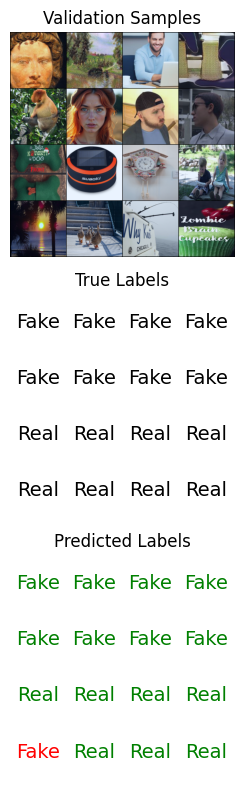

Epoch 1/10 Loss: 0.2656 | Train Acc: 96.14% | Val Acc: 94.89%

🔹 Epoch 2/10


Training: 100%|██████████| 3600/3600 [19:26<00:00,  3.09batch/s, Loss=0.2648, Train Acc=96.13%]


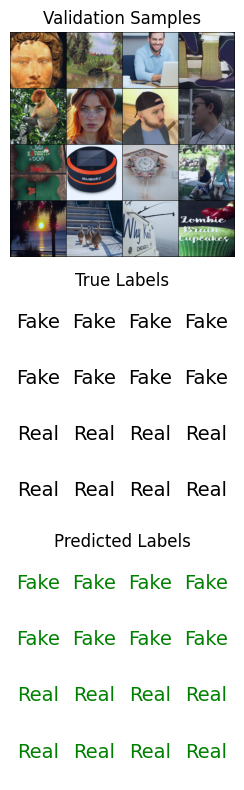

Epoch 2/10 Loss: 0.2648 | Train Acc: 96.13% | Val Acc: 95.52%

🔹 Epoch 3/10


Training: 100%|██████████| 3600/3600 [20:13<00:00,  2.97batch/s, Loss=0.2621, Train Acc=96.28%]


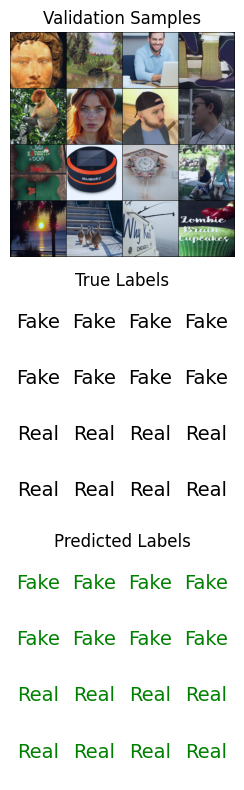

Epoch 3/10 Loss: 0.2621 | Train Acc: 96.28% | Val Acc: 93.81%

🔹 Epoch 4/10


Training: 100%|██████████| 3600/3600 [18:18<00:00,  3.28batch/s, Loss=0.2609, Train Acc=96.40%]


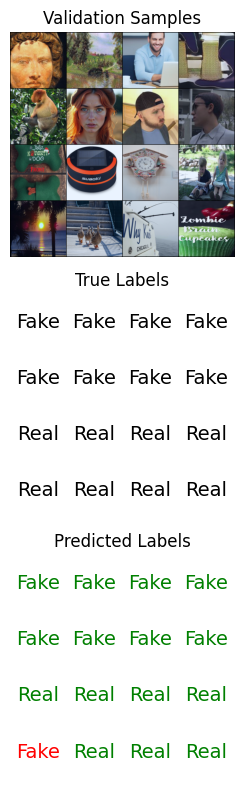

Epoch 4/10 Loss: 0.2609 | Train Acc: 96.40% | Val Acc: 94.34%

🔹 Epoch 5/10


Training: 100%|██████████| 3600/3600 [16:21<00:00,  3.67batch/s, Loss=0.2591, Train Acc=96.48%]


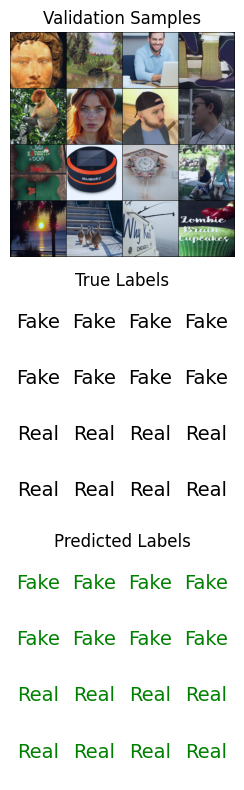

Epoch 5/10 Loss: 0.2591 | Train Acc: 96.48% | Val Acc: 96.15%

🔹 Epoch 6/10


Training: 100%|██████████| 3600/3600 [16:22<00:00,  3.66batch/s, Loss=0.2582, Train Acc=96.52%]


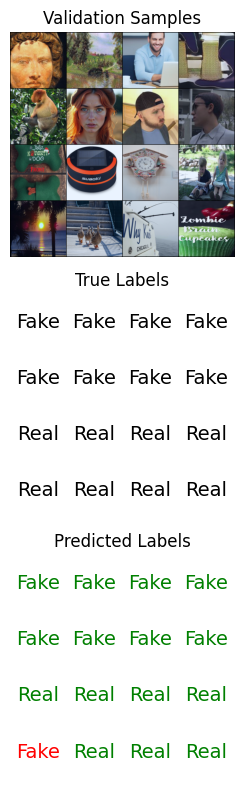

Epoch 6/10 Loss: 0.2582 | Train Acc: 96.52% | Val Acc: 95.76%

🔹 Epoch 7/10


Training: 100%|██████████| 3600/3600 [16:34<00:00,  3.62batch/s, Loss=0.2552, Train Acc=96.73%]


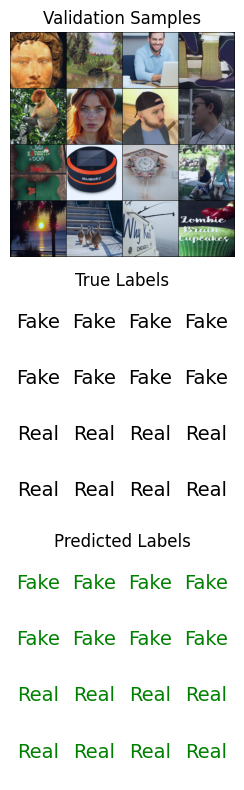

Epoch 7/10 Loss: 0.2552 | Train Acc: 96.73% | Val Acc: 95.97%

🔹 Epoch 8/10


Training: 100%|██████████| 3600/3600 [16:56<00:00,  3.54batch/s, Loss=0.2548, Train Acc=96.78%]


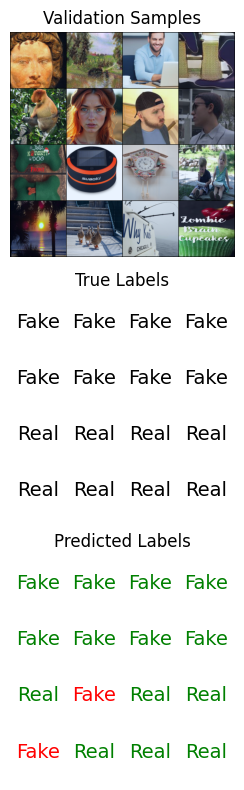

Epoch 8/10 Loss: 0.2548 | Train Acc: 96.78% | Val Acc: 95.82%

🔹 Epoch 9/10


Training: 100%|██████████| 3600/3600 [17:09<00:00,  3.50batch/s, Loss=0.2529, Train Acc=96.87%]


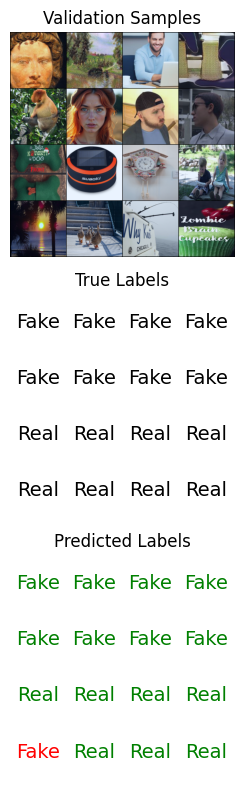

Epoch 9/10 Loss: 0.2529 | Train Acc: 96.87% | Val Acc: 94.22%

🔹 Epoch 10/10


Training: 100%|██████████| 3600/3600 [16:29<00:00,  3.64batch/s, Loss=0.2522, Train Acc=96.92%]


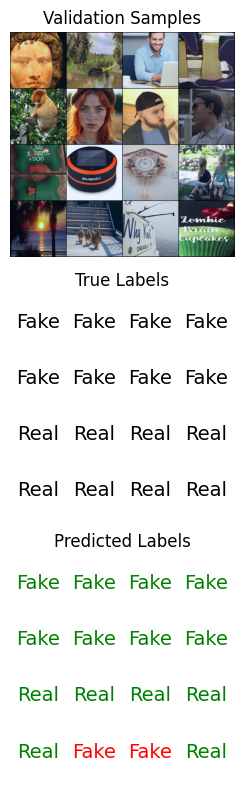

Epoch 10/10 Loss: 0.2522 | Train Acc: 96.92% | Val Acc: 94.92%

Training complete in 215.39 minutes.
Best validation accuracy: 96.15%


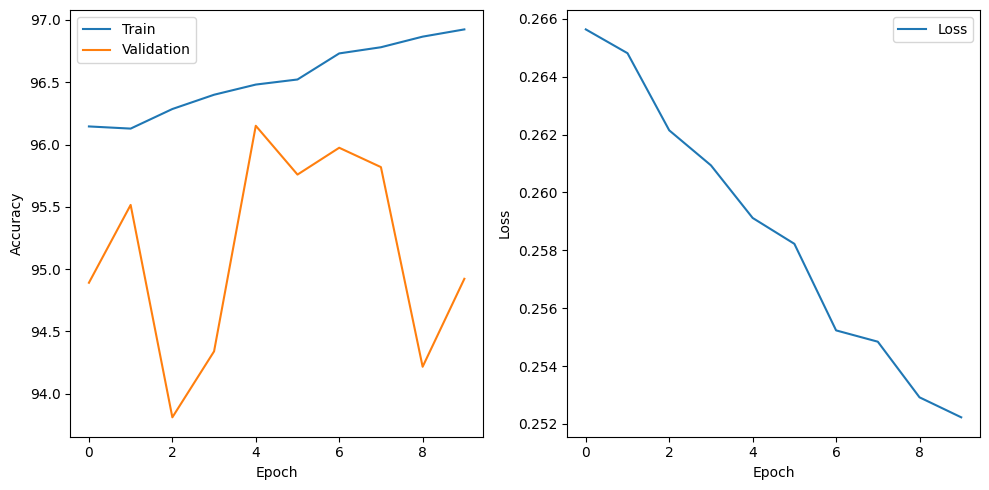

In [26]:
all_metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)